In [2]:
import os 
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input,InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report

In [1]:
def efficientnet_row(optimizer, loss, metrics, shape):
    image_input = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=shape)  # Change model to EfficientNet

    for layer in image_input.layers:
        layer.trainable = False
        layer._name = layer._name + str('_img')

    y = Flatten()(image_input.output)
    c = Dropout(0.4)(y)
    c = Dense(512)(c)
    c = Dense(256)(c)
    c = Dense(128)(c)
    output_layer = Dense(3, activation='softmax')(c)

    model = Model(inputs=image_input.input, outputs=output_layer)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [2]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [3]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()
     

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

NameError: name 'tf' is not defined

In [7]:
root='AFFINE_REG_SKS_MASK_2D_IMAGES_DIR/'
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 1901 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [8]:
EPOCH = 50
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-02-20 19:35:52.166096: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 19:35:52.881245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5


In [9]:
savepath = 'models'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'efficientnet_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = efficientnet_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
     

Epoch 1/50


2024-02-20 19:36:01.501473: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 33s 56ms/step - loss: 4.5155 - Accuracy: 0.4740 - AD_Precision: 0.2617 - CN_Precision: 0.3609 - MCI_Precision: 0.5917 - AD_Recall: 0.2530 - CN_Recall: 0.3553 - MCI_Recall: 0.5939 - val_loss: 2.1844 - val_Accuracy: 0.5749 - val_AD_Precision: 0.7000 - val_CN_Precision: 0.5157 - val_MCI_Precision: 0.6192 - val_AD_Recall: 0.0714 - val_CN_Recall: 0.7325 - val_MCI_Recall: 0.6736
Epoch 2/50
476/476 [==============================] - 21s 44ms/step - loss: 2.4097 - Accuracy: 0.5355 - AD_Precision: 0.3688 - CN_Precision: 0.4286 - MCI_Precision: 0.6411 - AD_Recall: 0.3554 - CN_Recall: 0.4194 - MCI_Recall: 0.6423 - val_loss: 3.3402 - val_Accuracy: 0.5324 - val_AD_Precision: 1.0000 - val_CN_Precision: 0.4653 - val_MCI_Precision: 0.6417 - val_AD_Recall: 0.0204 - val_CN_Recall: 0.8981 - val_MCI_Recall: 0.5021
Epoch 3/50
476/476 [==============================] - 21s 44ms/step - loss: 2.0824 - Accuracy: 0.5744 - AD_Precision: 0.3762 - CN_Precision: 0.5030 - M

In [11]:
model04.save(f"{savepath}/efficientnet.h5")

              precision    recall  f1-score   support

          AD       0.82      0.70      0.76        98
          CN       0.83      0.89      0.86       157
         MCI       0.85      0.86      0.85       239

    accuracy                           0.84       494
   macro avg       0.83      0.82      0.82       494
weighted avg       0.84      0.84      0.84       494



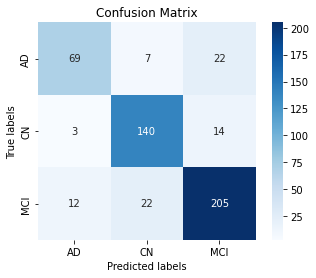

In [12]:
p = model04.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

In [14]:
np.save("efficientnet_predictions1.npy",p )

In [13]:
np.save("efficientnet1_predictions.npy", p1)

              precision    recall  f1-score   support

          AD       0.84      0.65      0.74        98
          CN       0.91      0.82      0.86       157
         MCI       0.79      0.92      0.85       239

    accuracy                           0.84       494
   macro avg       0.85      0.80      0.82       494
weighted avg       0.84      0.84      0.83       494



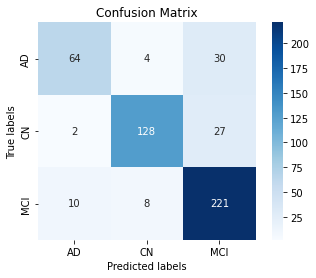

In [15]:
model07 = tf.keras.models.load_model('models/resnet50_model.h5')
savepath = 'models'
p2 = model07.predict(testing_image_datagen)
predicted_lab = p2.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("resnet1_predictions.npy", p2)

              precision    recall  f1-score   support

          AD       0.84      0.64      0.73        98
          CN       0.94      0.78      0.85       157
         MCI       0.79      0.95      0.86       239

    accuracy                           0.84       494
   macro avg       0.86      0.79      0.81       494
weighted avg       0.85      0.84      0.83       494



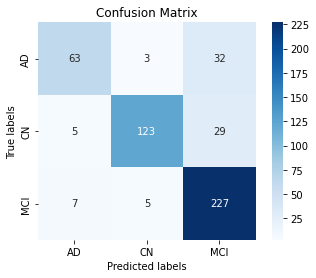

In [16]:
model08 = tf.keras.models.load_model('models/inceptionv3_model.h5')
savepath = 'models'
p3 = model08.predict(testing_image_datagen)
predicted_lab = p3.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("inceptionv31_predictions.npy", p3)

              precision    recall  f1-score   support

          AD       0.82      0.70      0.76        98
          CN       0.89      0.83      0.86       157
         MCI       0.83      0.91      0.87       239

    accuracy                           0.85       494
   macro avg       0.85      0.82      0.83       494
weighted avg       0.85      0.85      0.84       494



NameError: name 'dump_text' is not defined

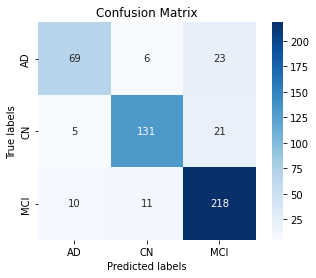

In [7]:
model09 = tf.keras.models.load_model('models/densenet201_model.h5')
savepath = 'models'
p3 = model09.predict(testing_image_datagen)
predicted_lab = p3.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("densenet201_predictions1.npy", p3)

In [8]:
np.save("densenet201_predictions1.npy", p3)

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Generate predictions from your models
predictions_resnet = np.load("resnet1_predictions.npy")
predictions_inception = np.load("inceptionv31_predictions.npy")
predictions_efficientnet = np.load("efficientnet_predictions1.npy")
predictions_xception = np.load("xception1_predictions.npy")
predictions_densenet = np.load("densenet201_predictions1.npy")

# Step 2: Apply class mapping to the predicted classes
class_mapping = {0: 0, 1: 1, 2: 3}  # Adjust according to your actual class labels

def map_class(cls):
    return class_mapping.get(cls, -1)  # Return -1 for unknown classes

predicted_classes_resnet_mapped = np.array([map_class(cls) for cls in np.argmax(predictions_resnet, axis=1)])
predicted_classes_inception_mapped = np.array([map_class(cls) for cls in np.argmax(predictions_inception, axis=1)])
predicted_classes_efficientnet_mapped = np.array([map_class(cls) for cls in np.argmax(predictions_efficientnet, axis=1)])
predicted_classes_xception_mapped = np.array([map_class(cls) for cls in np.argmax(predictions_xception, axis=1)])
predicted_classes_densenet_mapped = np.array([map_class(cls) for cls in np.argmax(predictions_densenet, axis=1)])

# Step 3: Stack the mapped predicted classes along with other features
stacked_features = np.column_stack((predicted_classes_resnet_mapped, 
                                    predicted_classes_inception_mapped, 
                                    predicted_classes_efficientnet_mapped,
                                    predicted_classes_xception_mapped,
                                    predicted_classes_densenet_mapped))

# Additional features can also be stacked with the predicted classes

# Step 4: Train a meta-model using the stacked dataset
X_train, X_test, y_train, y_test = train_test_split(stacked_features,true_lab, test_size=0.2, random_state=42)

meta_model = LogisticRegression()
meta_model.fit(X_train, y_train)

# Evaluate the meta-model
accuracy = meta_model.score(X_test, y_test)
print("Meta-model accuracy:", accuracy)
predictions_lr = meta_model.predict(X_test)

Meta-model accuracy: 0.8383838383838383


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Step 1: Make predictions using the meta-model
meta_predictions = meta_model.predict(X_test)

# Step 2: Compute metrics
accuracy = accuracy_score(y_test, meta_predictions)
precision = precision_score(y_test, meta_predictions, average='weighted')
recall = recall_score(y_test, meta_predictions, average='weighted')
conf_matrix = confusion_matrix(y_test, meta_predictions)

# Step 3: Print results
print("Meta-model accuracy:", accuracy)
print("Meta-model precision:", precision)
print("Meta-model recall:", recall)
print("Meta-model confusion matrix:")
print(conf_matrix)

Meta-model accuracy: 0.8383838383838383
Meta-model precision: 0.8645021645021645
Meta-model recall: 0.8383838383838383
Meta-model confusion matrix:
[[17  9  1]
 [ 1 23  2]
 [ 0  3 43]]


In [13]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Load the saved predictions
predictions_resnet = np.load("resnet1_predictions.npy")
predictions_inception = np.load("inceptionv31_predictions.npy")
predictions_efficientnet = np.load("efficientnet_predictions1.npy")
predictions_xception = np.load("xception1_predictions.npy")
predictions_densenet = np.load("densenet201_predictions1.npy")

# Combine the predictions
stacked_features = np.hstack((predictions_resnet, predictions_inception, predictions_efficientnet, predictions_xception, predictions_densenet))

# Load or define your target variable
# For example:
# target_variable = np.load("target_variable.npy")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(stacked_features, true_lab, test_size=0.2, random_state=42)

# Count occurrences of each class
class_counts = np.bincount(y_train)

# Determine the majority class and its count
majority_class = np.argmax(class_counts)
majority_class_count = np.max(class_counts)

# Oversample the minority class
minority_class_indices = np.where(y_train != majority_class)[0]
oversampled_indices = np.random.choice(minority_class_indices, size=majority_class_count, replace=True)
X_train_oversampled = np.concatenate((X_train, X_train[oversampled_indices]), axis=0)
y_train_oversampled = np.concatenate((y_train, y_train[oversampled_indices]), axis=0)

# Initialize Gradient Boosting classifier
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(gradient_boosting, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_oversampled, y_train_oversampled)

# Get the best model from the grid search
best_gradient_boosting = grid_search.best_estimator_

# Train the best model
best_gradient_boosting.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the test data
predictions = best_gradient_boosting.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Best Gradient Boosting accuracy:", accuracy)

Best Gradient Boosting accuracy: 0.8787878787878788


In [14]:
np.save("gradientboosting.npy",predictions )

In [15]:
np.save("stacking.npy",predictions_lr )